In [323]:
import math
import numpy as np
import numpy as np
import numpy.linalg
import random
import glob
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import skimage as sk
import skimage.transform as sktr
import skimage.color as color
import skimage.io as skio
import scipy.misc
from skimage.feature import corner_harris, peak_local_max
import scipy.spatial.distance as ds
from scipy import signal
import scipy
plt.rcParams['image.cmap'] = 'gray'
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Detect Corner Features In Image

### Functions

In [769]:
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1, indices=True)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


In [770]:
def ANMS(h, coords):
    plist = np.zeros((coords.shape[1],2))
    for i in range(coords.shape[1]):
        test = np.array([coords[:,j] for j in range(coords.shape[1]) if h[coords[:,i][0]][coords[:,i][1]] < h[coords[:,j][0]][coords[:,j][1]]])
        if test.shape[0] != 0:
            dists = test[((test[:,1]-coords[:,i][1])**2 + (test[:,0]-coords[:,i][0])**2).argmin()]
            mindist = ds.euclidean((coords[:,i][1],coords[:,i][0]),(dists[1],dists[0]))
            plist[i,:] = [i, mindist]
        else:
            plist[i,:] = [i, 10000.0]
    plist = plist[plist[:,1].argsort()]
    plist = plist[-500:]
    plist = np.array([[coords[:,i[0]][1],coords[:,i[0]][0]] for i in plist])
    return plist

### Main

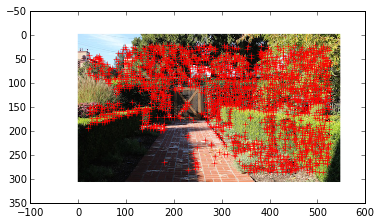

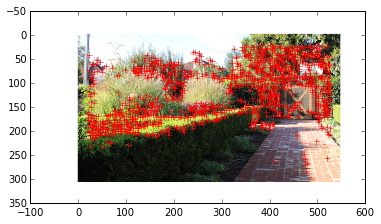

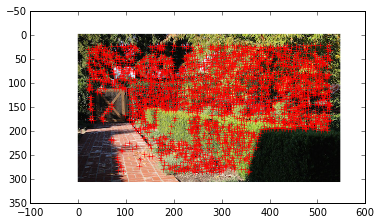

In [953]:
## Load in images and get Harris Corners
immid = plt.imread("im/m1.jpg")/255.
imgm = color.rgb2gray(immid)
hm, coordsm = get_harris_corners(imgm, 20)
plt.figure()
plt.imshow(immid)
plt.plot(coordsm[1,:], coordsm[0,:], "r+")
plt.show()

imleft = plt.imread("im/l1.jpg")/255.
imgl = color.rgb2gray(imleft)
hl, coordsl = get_harris_corners(imgl, 20)
plt.figure()
plt.imshow(imleft)
plt.plot(coordsl[1,:], coordsl[0,:], "r+")
plt.show()

imright = plt.imread("im/r1.jpg")/255.
imgr = color.rgb2gray(imright)
hr, coordsr = get_harris_corners(imgr, 20)
plt.figure()
plt.imshow(imright)
plt.plot(coordsr[1,:], coordsr[0,:], "r+")
plt.show()

/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


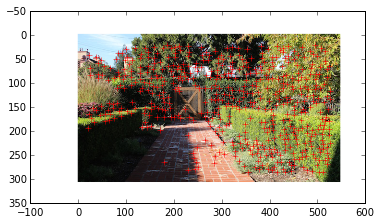

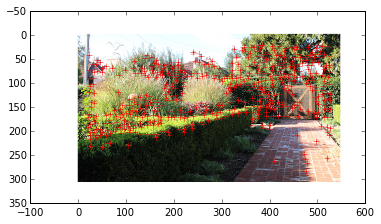

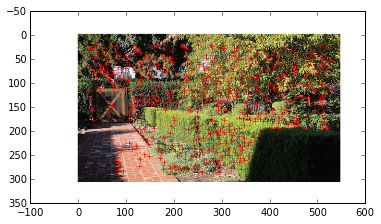

In [954]:
## Apply Adaptive Non-Maximal Suppression
coords2m = ANMS(hm,coordsm)
plt.figure()
plt.imshow(immid)
plt.plot(coords2m[:,0], coords2m[:,1], "r+")
plt.show()

coords2l = ANMS(hl,coordsl)
plt.figure()
plt.imshow(imleft)
plt.plot(coords2l[:,0], coords2l[:,1], "r+")
plt.show()

coords2r = ANMS(hr,coordsr)
plt.figure()
plt.imshow(imright)
plt.plot(coords2r[:,0], coords2r[:,1], "r+")
plt.show()

## Extract a Feature Descriptor for Each Feature Point

### Functions

In [955]:
def DescriptorExtractor(point,img):
    patch = sktr.rescale(img[point[1]-20:point[1]+20,point[0]-20:point[0]+20], 1.0/5.0)
    patch = np.reshape(patch, (64,))
    patch = (patch - mean(patch)) / std(patch)
    return patch

### Main

In [956]:
## Calculate Features for Each Image
featurelistm = np.array([DescriptorExtractor(x,imgm) for x in coords2m])
featurelistl = np.array([DescriptorExtractor(x,imgl) for x in coords2l])
featurelistr = np.array([DescriptorExtractor(x,imgr) for x in coords2r])

## Matching Feature Descriptors Between Images

### Functions

In [957]:
def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)


<ipython-input-957-22c5502e3975>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


In [958]:
def match(fl1,fl2,c1,c2):
    points1 = []
    points2 = []
    used = []
    D = dist2(fl1,fl2)
    NN1_2 = [f.argsort()[:2] for f in D]
    for p in range(len(NN1_2)):
        if D[p][NN1_2[p][0]]/D[p][NN1_2[p][1]] < 0.2:
            points1 += [c1[p]]
            points2 += [c2[NN1_2[p][0]]]
            used += [NN1_2[p][0]]
    return np.array(points1),np.array(points2)
    

### Main

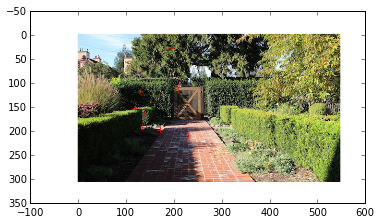

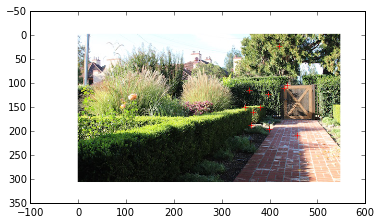

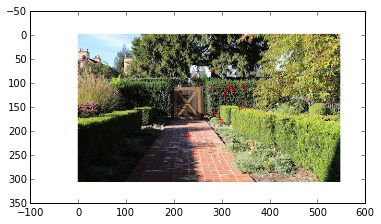

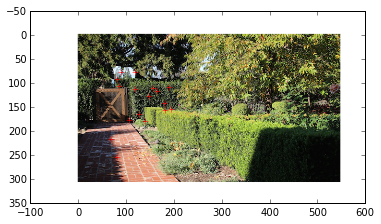

In [959]:
## Apply Feature Matching to left and mid and right and mid Images 
coords3ml,coords3l = match(featurelistm,featurelistl,coords2m,coords2l)
plt.figure()
plt.imshow(immid)
plt.plot(coords3ml[:,0], coords3ml[:,1], "r+")
plt.show()

plt.figure()
plt.imshow(imleft)
plt.plot(coords3l[:,0], coords3l[:,1], "r+")
plt.show()

coords3mr,coords3r = match(featurelistm,featurelistr,coords2m,coords2r)
plt.figure()
plt.imshow(immid)
plt.plot(coords3mr[:,0], coords3mr[:,1], "r+")
plt.show()

plt.figure()
plt.imshow(imright)
plt.plot(coords3r[:,0], coords3r[:,1], "r+")
plt.show()

## Use RANSAC to Compute Homography

### Functions

In [960]:
def computeH(im1_pts,im2_pts):
    A = []
    B = []
    for i in range(0, len(im1_pts)):
        x, y = im1_pts[i][0], im1_pts[i][1]
        u, v = im2_pts[i][0], im2_pts[i][1]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y])
        B.append([u])
        B.append([v])
    A = np.asarray(A)
    B = np.asarray(B)
    H = linalg.lstsq(A,B)
    H = numpy.reshape(numpy.vstack((H[0],[1])),(3,3))
    return H

In [961]:
def RANSAC(c1,c2):
    maxnc1 = []
    maxnc2 = []
    for k in range(1000):
        l = c1.shape[0]
        points = np.random.randint(l, size=4)
        H = computeH(c1[points],c2[points])
        nc1 = []
        nc2 = []
        for x in range(c1.shape[0]):
            point = np.array([[c1[x][0]],[c1[x][1]],[1]])
            newp = np.dot(H,point)
            newp = (newp/newp[2][0])
            newp = np.array([newp[0][0],newp[1][0]])
            if dist(newp,c2[x]) < 0.5:
                nc1 += [c1[x]]
                nc2 += [c2[x]]
        if len(nc1) > len(maxnc1):
            maxnc1 = nc1
            maxnc2 = nc2
    return np.array(maxnc1),np.array(maxnc2)

### Main

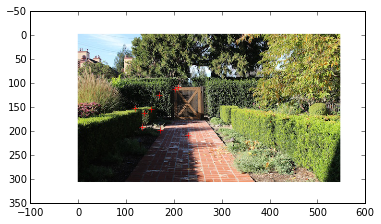

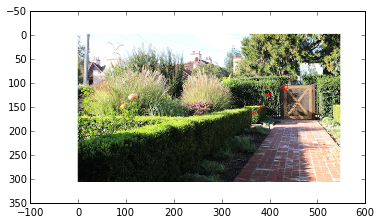

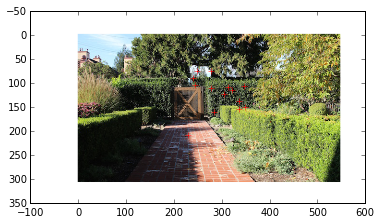

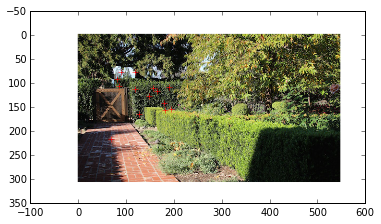

In [962]:
## Apply RANSAC to each pair of image points
ncl,ncml = RANSAC(np.array(coords3l),np.array(coords3ml))
plt.figure()
plt.imshow(immid)
plt.plot(ncml[:,0], ncml[:,1], "r+")
plt.show()

plt.figure()
plt.imshow(imleft)
plt.plot(ncl[:,0], ncl[:,1], "r+")
plt.show()

ncr,ncmr = RANSAC(np.array(coords3r),np.array(coords3mr))
plt.figure()
plt.imshow(immid)
plt.plot(ncmr[:,0], ncmr[:,1], "r+")
plt.show()

plt.figure()
plt.imshow(imright)
plt.plot(ncr[:,0], ncr[:,1], "r+")
plt.show()

## Produce A Mosaic

### Functions

In [963]:
def warpImage(im,H):
    c1 = np.dot(H,np.array([[0],[0],[1]]))
    c1 = (c1/c1[2][0])
    c2 = np.dot(H,np.array([[0],[im.shape[0]],[1]]))
    c2 = (c2/c2[2][0])
    c3 = np.dot(H,np.array([[im.shape[1]],[0],[1]]))
    c3 = (c3/c3[2][0])
    c4 = np.dot(H,np.array([[im.shape[1]],[im.shape[0]],[1]]))
    c4 = (c4/c4[2][0])
    minx = min([c1[0],c2[0],c3[0],c4[0]])
    miny = min([c1[1],c2[1],c3[1],c4[1]])
    maxx = max([c1[0],c2[0],c3[0],c4[0]])
    maxy = max([c1[1],c2[1],c3[1],c4[1]])
    nim = np.zeros((maxy-miny, (maxx-minx), im.shape[2]))
    points = [[x,y] for x in range(nim.shape[1]) for y in range(nim.shape[0])]
    Hinv = np.linalg.inv(H)
    for i, pt in enumerate(points):
        point = np.array([[pt[0]+minx],[pt[1]+miny],[1]])
        ndot = np.dot(Hinv,point)
        ndot = (ndot/ndot[2][0])
        npoint = (ndot[0][0],ndot[1][0])
        if npoint[0] <im.shape[1]-1 and npoint[0] > 0 and npoint[1] < im.shape[0]-1 and npoint[1] > 0:
            nim[pt[1],pt[0],:] = im[int(npoint[1]),int(npoint[0]),:]
    return nim,(c1,c2,c3,c4)

### Main

In [964]:
# Compute left and right Homographies and warp them to middle image plane
HL = computeH(ncl,ncml)
imwarpedl,pointsl = warpImage(imleft,HL)

HR = computeH(ncr,ncmr)
imwarpedr,pointsr = warpImage(imright,HR)

/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


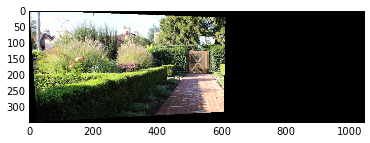

/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


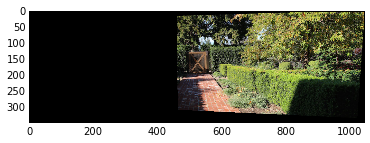

/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


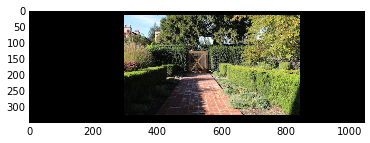

In [965]:
#Calculate final mosaic size and place left right and middle images into the correct locations.
minx = min([pointsl[0][0],pointsl[1][0]])
miny = min([pointsl[0][1],pointsl[2][1],pointsr[0][1],pointsr[2][1]])
maxx = max([pointsr[2][0],pointsr[3][0]])
maxy = max([pointsl[1][1],pointsl[3][1],pointsr[1][1],pointsr[3][1]])

maxlx = max([pointsl[2][0],pointsl[3][0]])
minrx = min([pointsr[0][0],pointsr[1][0]])

dif1 = pointsl[0][1]-miny
dif2 = pointsr[2][1]-miny


nl = np.zeros((maxy-miny, (maxx-minx), 3))
nl[dif1:imwarpedl.shape[0]+dif1,:imwarpedl.shape[1]] += imwarpedl
plt.figure()
plt.imshow(nl)
plt.show()
# Save left image to file path
scipy.misc.toimage(nl).save('panl2.jpg')

nr = np.zeros((maxy-miny, (maxx-minx), 3))
nr[dif2:imwarpedr.shape[0]+dif2,-imwarpedr.shape[1]:] += imwarpedr
plt.figure()
plt.imshow(nr)
plt.show()
# Save left image to file path
scipy.misc.toimage(nr).save('panr2.jpg')

nm = np.zeros(nl.shape)
nm[abs(miny):immid.shape[0]+abs(miny),abs(minx):immid.shape[1]+abs(minx)] += immid
plt.figure()
plt.imshow(nm)
plt.show()
# Save left image to file path
scipy.misc.toimage(nm).save('panm2.jpg')

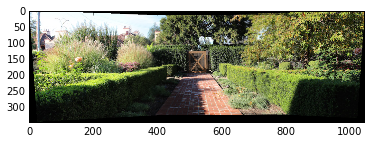

In [966]:
# Merge images using linear blending
new = np.zeros(nl.shape)
for i in range(new.shape[1]):
    left1 = abs(minx)
    right1 = minrx+abs(minx)
    if i <= left1:
        c1 = 1.0
        c2 = 1.0-c1
    if i > left1 and i < right1:
        c1 = (right1-float(i))/(right1-left1)
        c2 = 1.0-c1
    if i >= right1:
        c1 = 0.0
        c2 = 1.0-c1
        
    left2 = maxlx+abs(minx)
    right2 = immid.shape[1]+abs(minx)
    if i >= right2:
        c3 = 1.0
        c2 = 1.0-c3
    if i < right2 and i > left2:
        c3 = (left2-float(i))/(left2-right2)
        c2 = 1.0-c3
    if i <= left2:
        c3 = 0.0
    new[:,i,:] = nl[:,i,:]*c1 + nr[:,i,:]*c3 + nm[:,i,:]*c2
    
plt.figure()
plt.imshow(new)
plt.show()

# Save mosaic image to file path
scipy.misc.toimage(new).save('autopan2.jpg')

## Panorama Recognition

### Main

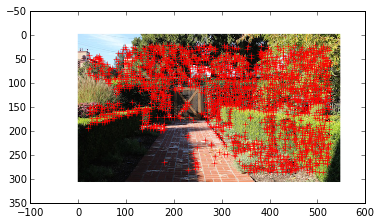

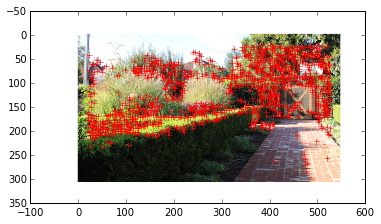

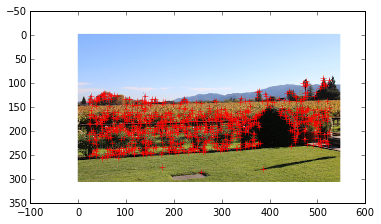

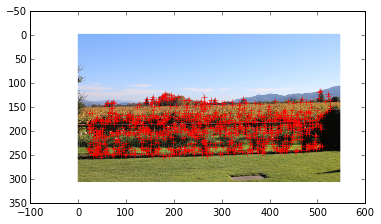

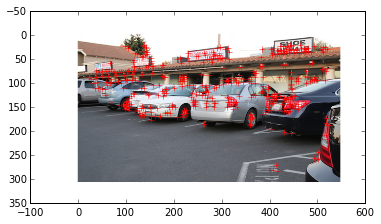

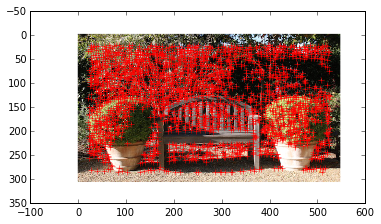

In [967]:
## Get Images
im_1 = plt.imread("im/m1.jpg")/255.
img_1 = color.rgb2gray(im_1)
h_1, coords_1 = get_harris_corners(img_1, 20)
plt.figure()
plt.imshow(im_1)
plt.plot(coords_1[1,:], coords_1[0,:], "r+")
plt.show()

im_2 = plt.imread("im/l1.jpg")/255.
img_2 = color.rgb2gray(im_2)
h_2, coords_2 = get_harris_corners(img_2, 20)
plt.figure()
plt.imshow(im_2)
plt.plot(coords_2[1,:], coords_2[0,:], "r+")
plt.show()

im_3 = plt.imread("im/r.jpg")/255.
img_3 = color.rgb2gray(im_3)
h_3, coords_3 = get_harris_corners(img_3, 20)
plt.figure()
plt.imshow(im_3)
plt.plot(coords_3[1,:], coords_3[0,:], "r+")
plt.show()

im_4 = plt.imread("im/m.jpg")/255.
img_4 = color.rgb2gray(im_4)
h_4, coords_4 = get_harris_corners(img_4, 20)
plt.figure()
plt.imshow(im_4)
plt.plot(coords_4[1,:], coords_4[0,:], "r+")
plt.show()

im_5 = plt.imread("im/m2.jpg")/255.
img_5 = color.rgb2gray(im_5)
h_5, coords_5 = get_harris_corners(img_5, 20)
plt.figure()
plt.imshow(im_5)
plt.plot(coords_5[1,:], coords_5[0,:], "r+")
plt.show()

im_6 = plt.imread("im/mid.jpg")/255.
img_6 = color.rgb2gray(im_6)
h_6, coords_6 = get_harris_corners(img_6, 20)
plt.figure()
plt.imshow(im_6)
plt.plot(coords_6[1,:], coords_6[0,:], "r+")
plt.show()

/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


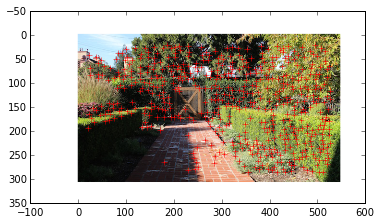

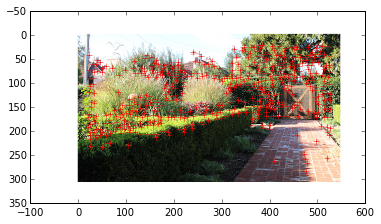

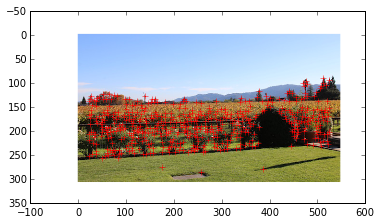

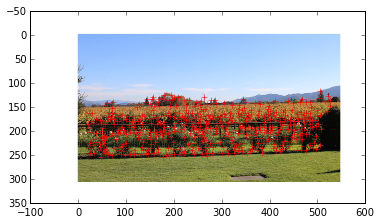

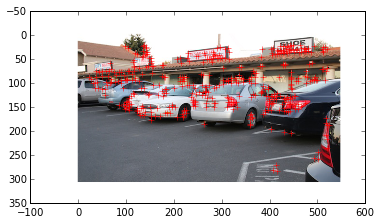

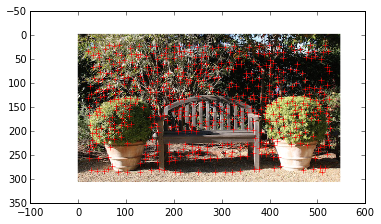

In [968]:
## Apply ANMS to All Images
coords2_1 = ANMS(h_1,coords_1)
plt.figure()
plt.imshow(im_1)
plt.plot(coords2_1[:,0], coords2_1[:,1], "r+")
plt.show()

coords2_2 = ANMS(h_2,coords_2)
plt.figure()
plt.imshow(im_2)
plt.plot(coords2_2[:,0], coords2_2[:,1], "r+")
plt.show()

coords2_3 = ANMS(h_3,coords_3)
plt.figure()
plt.imshow(im_3)
plt.plot(coords2_3[:,0], coords2_3[:,1], "r+")
plt.show()

coords2_4 = ANMS(h_4,coords_4)
plt.figure()
plt.imshow(im_4)
plt.plot(coords2_4[:,0], coords2_4[:,1], "r+")
plt.show()

coords2_5 = ANMS(h_5,coords_5)
plt.figure()
plt.imshow(im_5)
plt.plot(coords2_5[:,0], coords2_5[:,1], "r+")
plt.show()

coords2_6 = ANMS(h_6,coords_6)
plt.figure()
plt.imshow(im_6)
plt.plot(coords2_6[:,0], coords2_6[:,1], "r+")
plt.show()

In [969]:
## Calculate Features for All Images
featurelist_1 = np.array([DescriptorExtractor(x,img_1) for x in coords2_1])
featurelist_2 = np.array([DescriptorExtractor(x,img_2) for x in coords2_2])
featurelist_3 = np.array([DescriptorExtractor(x,img_3) for x in coords2_3])
featurelist_4 = np.array([DescriptorExtractor(x,img_4) for x in coords2_4])
featurelist_5 = np.array([DescriptorExtractor(x,img_5) for x in coords2_5])
featurelist_6 = np.array([DescriptorExtractor(x,img_6) for x in coords2_6])

In [970]:
## Create list of images, coordiantes, and features for easy access
imlist = [im_1,im_2,im_3,im_4,im_5,im_6]
coordlist = np.array([coords2_1,coords2_2,coords2_3,coords2_4,coords2_5,coords2_6])
fll = np.array([featurelist_1,featurelist_2,featurelist_3,featurelist_4,featurelist_5,featurelist_6])

In [971]:
## Find Images Matches
mat = []
for i in range(6):
    m = 10
    for j in range(6):
        if i != j:
            coords3_1,coords3_2 = match(fll[i],fll[j],coordlist[i],coordlist[j])
            Nf = coords3_1.shape[0]
            if Nf > 0:
                nc_1,nc_2 = RANSAC(coords3_1,coords3_2)
            else:
                nc_1 = np.array([])
            Ni = nc_1.shape[0]
            if Ni > (5.9 + 0.22*Nf):
                m = j
    mat += [m]

/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Annalise/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


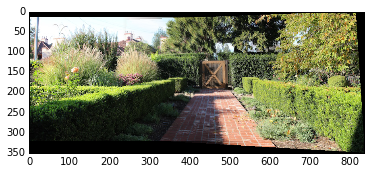

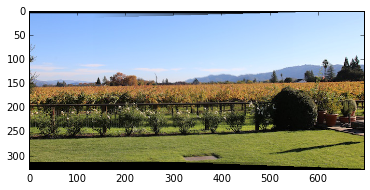

In [972]:
## Create Resulting Panaoramas With matching Images
used = []
for x in range(6):
    if mat[x] != 10 and mat[x] not in used:
        used += [x, mat[x]]
        coords3_1,coords3_2 = match(fll[x],fll[mat[x]],coordlist[x],coordlist[mat[x]])
        nc_1,nc_2 = RANSAC(coords3_1,coords3_2)
        H_1 = computeH(nc_1,nc_2)
        imwarped_1,points_1 = warpImage(imlist[x],H_1)        
        simg = imlist[mat[x]]
        minx = min([points_1[0][0],points_1[1][0],0])
        miny = min([points_1[0][1],points_1[2][1],0])
        maxx = max([points_1[2][0],points_1[3][0],simg.shape[1]])
        maxy = max([points_1[1][1],points_1[3][1],simg.shape[0]])
        
        n_1 = np.zeros((maxy-miny, (maxx-minx), 3))
        if minx < 0:
            max1x = max([points_1[2][0],points_1[3][0]])
            dif = points_1[0][1]-miny
            n_1[dif:imwarped_1.shape[0]+dif,:imwarped_1.shape[1]] += imwarped_1
        else:
            max1x = min([points_1[0][0],points_1[1][0]])
            dif = points_1[2][1]-miny
            n_1[abs(dif):imwarped_1.shape[0]+abs(dif),-imwarped_1.shape[1]:] += imwarped_1

        n_2 = np.zeros(n_1.shape)
        n_2[abs(miny):simg.shape[0]+abs(miny),abs(minx):simg.shape[1]+abs(minx)] += simg
        
        new = np.zeros(n_1.shape)
        for i in range(new.shape[1]):
            if minx < 0:
                left1 = abs(minx)
                right1 = min1x+abs(minx)
                if i <= left1:
                    c1 = 1.0
                    c2 = 1.0-c1
                if i > left1 and i < right1:
                    c1 = (right1-float(i))/(right1-left1)
                    c2 = 1.0-c1
                if i >= right1:
                    c1 = 0.0
                    c2 = 1.0-c1
            else:
                left2 = max1x+abs(minx)
                right2 = immid.shape[1]+abs(minx)
                if i >= right2:
                    c1 = 1.0
                    c2 = 1.0-c1
                if i < right2 and i > left2:
                    c1 = (left2-float(i))/(left2-right2)
                    c2 = 1.0-c1
                if i <= left2:
                    c1 = 0.0
                    c2 = 1.0-c1
            new[:,i,:] = n_1[:,i,:]*c1 + n_2[:,i,:]*c2

        plt.figure()
        plt.imshow(new)
        plt.show()
        
        # Save mosaic image to file path
        scipy.misc.toimage(new).save('pan'+str(x)+'.jpg')
        